# Artificial Neural Networks
Artificial neural networks (ANNs) or simulated neural networks (SNNs) are a subset of machine learning, and are at the heart of deep learning algorithms. Their name and structure are inspired by the human brain, mimicking how biological neurons signal to one another. Neural networks reflect the behavior of the human brain, allowing computer programs to recognize patterns and solve common problems in the fields of AI, machine learning, and deep learning.

There are many kinds of neural networks, such as _Convolution Neural Networks(CNNs), Recurrent Neural Networks(RNNs)_ and etc. In this notebook, we'll be implementing a simple neural network from scratch just using NumPy. We'll have a brief explanation of the similarity  between _Logistic Regression_ and a simple _Neural Net_, and we'll build up our model from that.

### Learning goals

- Learning the similarity between _Logistic Regression_ and a simple _Neural Network_
- Implementing a simple _neural network_ to recognize handwritten digits

### References

- [1] [Stanford CS229 Machine Learning](https://www.youtube.com/playlist?list=PLoROMvodv4rMiGQp3WXShtMGgzqpfVfbU), [CS229 lecture notes](http://cs229.stanford.edu/syllabus.html)
- [2] [Seyed Naser Razavi's machine learning class](https://www.youtube.com/playlist?list=PLW529xl11jnnupZKT5Og4pwHPoRFQRQz_) (Persian)
- [3] [The Softmax Function Derivative](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

### Helpers

In [2]:
def train_valid_test_split(X, y, val_size=.2, test_size=.2, shuffle=False):
    if val_size < 0 or test_size < 0:
        
        raise EnvironmentError("validation or test size should not be negative!")
    
    if val_size + test_size >= 1.:
        raise EnvironmentError("validation + test size should be lesser than 1!")
    
    x_data, y_data = X, y
    if shuffle:
        for _ in range(3):
            temp = list(zip(x_data.T, y_data.T))
            random.shuffle(temp)
            x_data, y_data = zip(*temp)
            x_data = np.array(list(x_data)).T
            y_data = np.array(list(y_data)).T
        
    
    val_indx = int(val_size * x_data.shape[1])
    test_indx = int(test_size * x_data.shape[1])
    X_val, X_test, X_train = x_data[:, :val_indx], x_data[:, val_indx:val_indx+test_indx], x_data[:, val_indx+test_indx:]
    y_val, y_test, y_train = y_data[:, :val_indx], y_data[:, val_indx:val_indx+test_indx], y_data[:, val_indx+test_indx:]
    
    return X_train, X_test, X_val, y_train, y_test, y_val

def accuracy(y_pred, y_true):
    return 100. * sum(np.argmax(y_pred, axis=0) == np.argmax(y_true, axis=0)) / y_true.shape[1]

### Activation Functions

In [3]:
# rectified linear unit
def ReLU(x):
    x = np.where(x < 0, 0, x)
    return x
# derivative of ReLU
def dReLU(x):
    x = np.where(x < 0, 0, x)
    x = np.where(x > 0, 1, x)
    return x

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1. - tanh(x)**2

# sigmoid function
def sigm(x):
    return 1. / (1. + np.exp(-x))

# derivative of sigmoid function
def dsigm(x):
    z = sigm(x)
    return z * (1. - z)
def softmax(x):
    x = x - np.max(x, axis=0, keepdims=True)
    exp_x = np.exp(x)
    exp_x /= np.sum(exp_x, axis=0, keepdims=True)
    return exp_x
def dsoftmax(y_hat, y):
    return y_hat - y

### Logistic Regression
_Logistic Regression_ is one of the fundamental and popular algorithms to solve classification problems. As an example, suppose we want to classify images based on whether there is a cat in them or not. So, the presence of a cat is $y = 1$, and the absence of a cat will be $y = 0$.

The first thing we need to do to classify cat images using Logistic Regression is to vectorize the images. We know that images can be represented in 3D matrices, so if we take the color cat image below of size $64\times64\times3$ (3 for the RGB channel) and flatten it into a vector, we'll have 12288 numbers to represent those pixels. We'll call it $x$.

<img src='imgs/cat0.png' width='85%' height='50%' style="float:center">

Now, since we have an input vector $x$, we can take it and push it in the logistic operation (as illustrated below), which has two parts. The first part (the linear part) is $Wx + b$, and the second part (the activation part) is the sigmoid function. The sigmoid function is a function that takes a number between $+\infty$ and $-\infty$, then maps it between 1 and 0. The operations' output is a number showing the probability of presence of a cat in the image, and it's called $\hat{y}$.

$$\hat{y} = \sigma(Wx + b) = \frac{1}{1 + e^{-(Wx + b)}} \tag{1}$$
The larger the $\hat{y}$ is, the higher the probability of a cat being in the input image is.

Bear in mind that since the shape of vector input $x$ is (12288, 1), $W$ should be of shape (1, 12288), and $b$ will be just a single number.

<img src='imgs/cat1.jpg' width='85%' height='50%' style="float:center">

From now on, we'll call the __multi-class logistic regression__ model illustrated above a __neuron__.

Once we have a neuron, we need to train it (obviously after initializing the weights and the bias). To do that, we need to find the optimal weights and the optimal bias. After finding the optimal values, we'll use them to predict.

Finding the optimal $W$ and $b$ means defining a loss function. That loss function would be called the __Logistic loss__, which we want to minimize it for each input we give to it:
$$\begin{align}
\mathscr{L} &= - (ylog\hat{y} + (1 - y)log(1 - \hat{y})) \tag{2}\\
W &= W - \alpha \frac{\partial\mathscr{L}}{\partial W}\\
b &= b - \alpha \frac{\partial\mathscr{L}}{\partial b}
\end{align}$$

And, if we give the neuron $m$ inputs at the same time, the _Logistic loss_ becomes:

$$\mathscr{L} = - \frac1m \sum_{i=1}^m(y^{(i)}log\hat{y}^{(i)} + (1 - y^{(i)})log(1 - \hat{y}^{(i)}))\tag{3}$$

And $X$ is:

$$
X = 
\begin{pmatrix}
\big| & \big| & \cdots & \big|\\
x^{(1)} & x^{(2)} & \ddots & x^{(m)}\\
\big| & \big| & \cdots & \big|
\end{pmatrix}$$

$y^{(i)}$ denotes the correct answer for $x^{(i)}$.

Now, what if we want to classify other things, like a dog, a mouse, etc.? To do that, we'll add more neurons to our model.

<img src='imgs/multiClass.png' width='40%' height='40%' style="float:center">

Now, since we have a __Layer__ of neurons, the shape of $W$ becomes $(n, 12288)$ and we also have $n$ biases ($n$ is the number of neurons in the layer, or the number of classes in the model). Also, the correct label of the input image, and the operations' output $\hat{y}$ become vectors of size $n$:

$$\begin{align}
y = \pmatrix{y_1=0 \\ y_2=0 \\ .\\ y_j=1\\. \\ .\\ y_k=1 \\ . \\ y_n=0}, \hat{y} &= \pmatrix{\hat{y}_1 \\ \hat{y}_2 \\ .\\ . \\ . \\ \hat{y}_n} \\
\hat{y}_i = \sigma(W_i x + b_i) &= \frac{1}{1 + e^{-(W_i x + b_i)}} \forall i \in {1,...,n}\tag{4}
\end{align}$$

The reason for having $y_j=1$ and $y_k=1$ is that the image might include multiple classes. Like an image of a cat and a dog.

And the _Logistic loss_ function will be:
$$\mathscr{L} = \sum_{i=1}^n -(y_ilog\hat{y}_i + (1-y_i)log(1-\hat{y}_i))\tag{5}$$

Also, if $m$ inputs are given to our model, then $y$ and $\hat{y}$ become matrices of shape (n, m), and the _Logistic loss_ becomes:
$$\mathscr{L} = \frac1m \sum_{i=1}^m \mathscr{L}^{(i)} = -\frac1m \sum_{i=1}^m\sum_{j=1}^n (y_j^{(i)}log\hat{y}_j^{(i)} + (1-y_j^{(i)})log(1-\hat{y}_j^{(i)}))\tag{6}$$

This model might work well in some cases. But, there are cases that we have a __constraint__ where there is only one possible outcome.
- Think about healthcare. There are many models made to detect if a specific disease exists based on cell microscopic images. Usually, there are no overlaps among diseases, meaning we want to classify a particular disease among a large number of diseases. The model above would still work, but it will not be optimal because it takes longer to train. Maybe one disease is super rare, and therefore one of the neurons would rarely get trained. Thus we'll work with another model and put on the constraint, and we let the neurons learn by creating interactions between them.


- Another example is classifying __HandWritten Digits__ since the given input image belongs to only one possible outcome (not two or more). We'll be focusing on this example and implement a model that can classify handwritten digits.

### Loading data

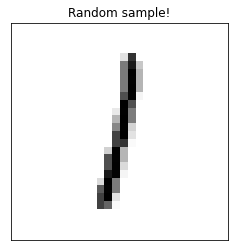

In [4]:
file_path = "C://Users//cafestock//Desktop//data analysis//ML//Neural Networks//data"
data_train = pd.read_csv(file_path +"//train.csv")

x = np.array(data_train.drop(columns=["label"])).T /256.
y = np.zeros((10, 42000))

for i in range(42000):
    y[data_train.iloc[i]["label"], i] = 1.

plt.figure(figsize=(4, 4))
plt.imshow(x[:, random.randint(0, 41999)].reshape(28, 28), interpolation='nearest', cmap=plt.cm.Greys)
plt.xticks([])
plt.yticks([])
plt.title("Random sample!")
plt.show()

First things first, let's deal with the constraint using __softmax__.

## Softmax Classifier

In the multi-class logistic regression model that we defined above (using sigmoid function), we are training $n$ different classifiers. Therefore, the sum of the probabilities for different classes might not be __1__. In this new model, in which we're training $n = 10$ classifiers, after computing the linear part ($W_ix + b_i$) in each neuron, we will use __softmax__ instead of sigmoid function in the activation part. Thus, instead of having $n$ different classifiers which are acting separately, we have only one classifier which is able to distinguish among $n$ different classes, and the sum of the probabilities equals __1__.

<img src='imgs/softmax_classifier_for_digits.png' width='50%' height='50%' style="float:center">

### Softmax Function

Suppose we have a vector $z$ consisting of the results computed in the linear part and related to different classes for given input $x$ ($z \in \mathbb{R}^{10}$). Then, $softmax(z)$ computes a vector of probabilities (one probability for each class). In fact, the $k$th element of this vector represents the probalitity of $x$ being of class $k$. This is computed as following:
$$\begin{align}z &= Wx + b\\
s_k = \text{softmax}(z)_k &= \frac{e^{z_k}}{\sum_{i=1}^{10} e^{z_i}}, \forall k \in 1,...,10 \tag{7}\\\\
\hat{y} = s &= \pmatrix{s_1 \\ s_2 \\ . \\ . \\ . \\ s_{10}}
\end{align}$$

### Categorical Cross Entropy Loss Function

Now, we need a new loss function to use for finding the optimal weights and the optimal bias. This loss function is called __Categorical Cross Entropy Loss Function__:

$$\mathscr{L} = -\sum_{i=1}^{10}y_ilog(s_i)\tag{8}$$
In which $y$ is the correct class for given input $x$. Surprisingly, it's very similar to the _Logistic loss_. The reason for it not having the $(1 - y)log(1 - s)$ part is explained in the following.

Suppose that a given input $x$ belongs to class $k$. Thus, all $y_i$s are 0, except for $y_k$ which is 1. So, $\mathscr{L}(x) = -\sum_{i=1}^{10}y_ilog(s_i) = -y_klog(s_k) = -log(s_k)$.
Minimizing $\mathscr{L}$ means maximizing $log(s_k)$, or maximizing $s_k$. Maximizing $s_k$ will result in minimizing other $s_i$s consequently, since $\sum_{i=1}^{10} s_i = 1$ and $0 \le s_i \le 1$. That's the reason for not including $(1 - y)log(1 - s)$ in the equation.

Just a reminder, with $m$ inputs, $y$ and $s$ become metrices of shape (n, m), or (10, m), and the loss function will be:

$$\mathscr{L} = -\frac1m \sum_{i=1}^{m}\sum_{j=1}^{10}y_j^{(i)}log(s_j^{(i)})\tag{9}$$

### Optimization

Let's cumpute $\frac{\partial\mathscr{L}}{\partial W}$ and $\frac{\partial\mathscr{L}}{\partial b}$ to find the optimal values for $W$ and $b$. Using the chain rule we get:
$$\begin{align} 
\frac{\partial\mathscr{L}}{\partial W} &= \sum_{i=1}^{10} \frac{\partial\mathscr{L}}{\partial s_i} \cdot \frac{\partial s_i}{\partial z} \cdot \frac{\partial z}{\partial W} \tag{10}\\\\
\frac{\partial\mathscr{L}}{\partial b} &= \sum_{i=1}^{10} \frac{\partial\mathscr{L}}{\partial s_i} \cdot \frac{\partial s_i}{\partial z} \cdot \frac{\partial z}{\partial b} \tag{11}
\end{align}$$

Solving for $\frac{\partial\mathscr{L}}{\partial s_i}$:
$$\frac{\partial\mathscr{L}}{\partial s_i} = \frac{\partial}{\partial s_i}(-y_ilog(s_i) + \sum_{j \neq i} -y_jlog(s_j)) = -\frac{y_i}{s_i}\tag{12}$$

Solving for $\frac{\partial s}{\partial z}$: when talking about the derivative of the softmax function, we actually talk about its Jacobian matrix, which is the matrix of all first-order partial derivatives:

$$
\frac{\partial s}{\partial z} = J_{softmax} = 
\pmatrix{\frac{\partial s_1}{z} \\ \frac{\partial s_2}{z} \\ \vdots \\ \frac{\partial s_i}{z}  \\ \vdots \\ \frac{\partial s_{10}}{z}} =
\begin{pmatrix}\frac{\partial s_1}{\partial z_1} &
\frac{\partial s_1}{\partial z_2} & \cdots & \frac{\partial s_1}{\partial z_{10}} \\
\frac{\partial s_2}{\partial z_1} & \frac{\partial s_2}{\partial z_2} & \cdots &
\frac{\partial s_2}{\partial z_{10}}\\
\vdots & \vdots & \ddots & \vdots\\
\frac{\partial s_{10}}{\partial z_1} & \frac{\partial s_{10}}{\partial z_2} & \cdots &
\frac{\partial s_{10}}{\partial z_{10}}
\end{pmatrix}
$$

Since the outputs of the softmax function are strictly positive values, we can make the above derivations super short, by applying the following trick: instead of taking the partial derivatives of the outputs, we take the partial derivatives of the log of the outputs (also called __logarithmic derivative__):

$$\begin{align}
\frac{\partial}{\partial z_j}log(s_i) = \frac{1}{s_i} \cdot \frac{\partial s_i}{\partial z_j} \\
\frac{\partial s_i}{\partial z_j} = s_i \cdot \frac{\partial}{\partial z_j}log(s_i)\tag{13}
\end{align}$$

And $log(s_i)$ is:
$$log(s_i) = log(\frac{e^{z_i}}{\sum_{l=1}^{10} e^{z_l}}) = z_i - log(\sum_{l=1}^{10} e^{z_l})$$

The partial derivative of the above expression is:
$$\frac{\partial}{\partial z_j}log(s_i) = \frac{\partial z_i}{\partial z_j} - \frac{\partial}{\partial z_j}log(\sum_{l=1}^{10} e^{z_l})\tag{14}$$

Considering the first term on the right hand side:
$$
\frac{\partial z_i}{\partial z_j} = \bigg\{ \begin{array} \text{1}, & \text{if} \ \ i = j \\ 0, & otherwise 
\end{array}
$$

It can be replaced with the indicator function $1\{arg\}$ (the indicator function returns 1 if its argument is true, and 0 otherwise). Let's rewrite Eq.14 :

$$\begin{align}
\frac{\partial}{\partial z_j}log(s_i) &= 1\{i = j\} - \frac{1}{\sum_{l=1}^{10} e^{z_l}} \cdot \ (\frac{\partial}{\partial z_j}\sum_{l=1}^{10} e^{z_l}) \\
&= 1\{i = j\} - \frac{e^{z_j}}{\sum_{l=1}^{10} e^{z_l}}\\ 
&= 1\{i = j\} - s_j\tag{15}
\end{align}$$

From equations 13 and 15, we have:
$$\frac{\partial s_i}{\partial z_j} = s_i \cdot (1\{i = j\} - s_j) \tag{16}$$

Thus, the jacobian matrix becomes:

$$
\frac{\partial s}{\partial z} = J_{softmax} =
\begin{pmatrix}
s_1 \cdot (1 - s_1) & -s_1\cdot s_2 & \cdots & -s_1\cdot s_{10}\\
-s_2 \cdot s_1 & s_2 \cdot (1 - s_2) & \cdots & -s_2\cdot s_{10}\\
\vdots & \vdots & \ddots & \vdots\\
-s_{10} \cdot s_1 & -s_{10} \cdot s_2 & \cdots & s_{10}\cdot (1 - s_{10})\\
\end{pmatrix} \tag{17}
$$

Now, from the results from equations 12 and 17 and using the __broadcasting technique__, we'll get:

$$
\frac{\partial\mathscr{L}}{\partial s} \cdot \frac{\partial s}{\partial z} = 
\pmatrix{\frac{y_1}{s_1} \\ \frac{y_2}{s_2}\\ \vdots \\ \frac{y_{10}}{s_{10}}}
\pmatrix
{
s_1 \cdot (s_1 - 1) & s_1\cdot s_2 & \cdots & s_1\cdot s_{10}\\
s_2 \cdot s_1 & s_2 \cdot (s_2 - 1) & \cdots & s_2\cdot s_{10}\\
\vdots & \vdots & \ddots & \vdots\\
s_{10} \cdot s_1 & s_{10} \cdot s_2 & \cdots & s_{10}\cdot (s_{10} - 1)\\
} =
\pmatrix
{
0 & 0 & 0 & 0 & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
s_1 & s_2 & \cdots & s_k - 1 & \cdots & s_{10}\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
0 & 0 & 0 & 0 & \cdots & 0\\
}_{10 \times 10}\tag{18}
$$

Thus:

$$ 
\sum_{i=1}^{10} \frac{\partial\mathscr{L}_i}{\partial s_i} \cdot \frac{\partial s_i}{\partial z} = 
\begin{pmatrix}s_1 \\ s_2 \\ \vdots \\ s_k - 1 \\ \vdots \\ s_{10} \end{pmatrix} =
\begin{pmatrix}s_1 \\ s_2 \\ \vdots \\ s_k \\ \vdots \\ s_{10} \end{pmatrix} - 
\begin{pmatrix}y_1=0 \\ y_2=0 \\ \vdots \\ y_k = 1 \\ \vdots \\ y_{10}=0 \end{pmatrix}=
s - y
\tag{19}
$$

Bear in mind that since the input vector $x$ belongs to class $k$, all $y_i$s are 0 except for $y_k$, which is 1. That's why there is only one nonzero row in the $10 \times 10$ matrix above.

### Loss Function

In [5]:
def softmax_cross_entropy_cost(y_hat, y):
    cost = np.mean(-np.sum(y * np.log(y_hat+1e-9), axis=0))
    return cost

def dsoftmax_cross_entropy_cost(y_hat, y):
    # equation 19: derivative of Loss with respect to z
    return dsoftmax(y_hat, y)

And finally we plug Eq19 back into Eq10 and Eq11 to compute $\frac{\partial\mathscr{L}}{\partial W}$ and $\frac{\partial\mathscr{L}}{\partial b}$. Two derivations remain, $\frac{\partial z}{\partial W}$ and $\frac{\partial z}{\partial b}$ :

$$\begin{align}
\frac{\partial z}{\partial W} &= \frac{\partial}{\partial W}(Wx + b) = x^T \\
\frac{\partial z}{\partial b} &= \frac{\partial}{\partial b}(Wx + b) = 
\pmatrix{1 \\ 1 \\ \vdots \\ 1}_{10 \times 1}
\end{align}$$

The reason for $\frac{\partial z}{\partial W} = x^T$ is that $\frac{\partial z}{\partial W}$ needs to be of shape (10, 12288), just like $W$, and the only way to achieve this is to take the dot product of vector $s - y$ with shape (10, 1) and vector $x^T$ with shape (1, 12288). 

$$\begin{align}
\frac{\partial\mathscr{L}}{\partial W} &= (s - y)x^T \\\\
\frac{\partial\mathscr{L}}{\partial b} &= s - y\\\\
W &= W - \alpha \frac{\partial\mathscr{L}}{\partial W} \\
b &= b - \alpha \frac{\partial\mathscr{L}}{\partial b}\\
(\alpha \ &\text{is the learning rate})
\end{align}$$

And once more, given $m$ inputs, $\frac{\partial\mathscr{L}}{\partial z} = \frac{\partial\mathscr{L}}{\partial s} \cdot \frac{\partial s}{\partial z} = y - s$ would be of shape $(10, m)$, and every coulumn of it, as you would already know, equals $s^{(i)} - y^{(i)}$ for each given $x^{(i)}$, and $\frac{\partial\mathscr{L}}{\partial W} = \frac1m \cdot (s - y)X^T$ (we divide by $m$ because of Eq9).

Let's see what we got so far. We have a model with a layer of ten neurons, we have our data which we're going to train the model with it, and we know how to get it to work. OK! No more explanations, for now. Further down the road, we'll add more layers, and we'll find out how to optimize for that.

__Now, Let's see all of this in practice.__

### Preprocessing data

In [6]:
X_train, X_test, X_val, y_train, y_test, y_val = train_valid_test_split(x, y, test_size=.15, val_size=.15, shuffle=True)
# mean value of features
mu = np.mean(X_train, axis=1, keepdims=True)

# remove mean vector from all data
X_train -= mu
X_val -= mu
X_test  -= mu

Let's see how `mu` variable looks:

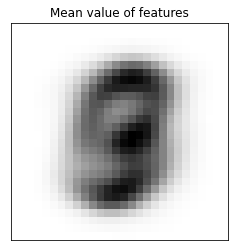

In [7]:
plt.figure(figsize=(4, 4))
plt.imshow(mu.reshape(28, 28), interpolation='nearest', cmap=plt.cm.Greys)
plt.xticks([])
plt.yticks([])
plt.title("Mean value of features")
plt.show()

In [8]:
# the following class, allows us to create layers with varying neuron counts
class Layer:
    
    def __init__(self, in_shape, n_neurons, Activation="ReLU"):
        if in_shape <= 0 or n_neurons <= 0:
            raise EnvironmentError("Input values should be positive!")
        
        self.shape = np.array([n_neurons, in_shape])
        self.b = np.zeros((self.shape[0], 1)) # the biases
        
        # Initializing Wieghts and specifying activation function for the layer
        if Activation == "ReLU":
            self.Activation = ReLU
            self.dActivation = dReLU
            self.W = np.random.randn(*self.shape) * np.sqrt(2. / self.shape[1])
        elif Activation == "sigm":
            self.Activation = sigm
            self.dActivation = dsigm
            self.W = np.random.randn(*self.shape) * np.sqrt(1. / self.shape[1])
        elif Activation == "tanh":
            self.Activation = tanh
            self.dActivation = dtanh
            self.W = np.random.randn(*self.shape) * np.sqrt(1. / sum(self.shape))
        elif Activation == "Linear":
            self.Activation = lambda x: x
            self.dActivation = lambda x: 1.
            self.W = np.random.randn(*self.shape)
        elif Activation == "soft":
            self.Activation = softmax
            self.dActivation = dsoftmax
            self.W = np.random.randn(*self.shape) * 0.001
        else:
            raise EnvironmentError("Activation function not defined!")
            
        self.x = None # the given input to the Layer        
        self.z = None # the result from the linear part (Wx + b)
        self.a = None # the result from the activation part (activation(z))
        
    def train(self, x):
        self.x = x
        self.z = self.W @ self.x + self.b # computing the linear part
        self.a = self.Activation(self.z) # computing the activation part

In [9]:
# with the help of the following class we can create a Neural Network model with multiple and different layers,
# choose a specific lost function to train the model based on it, define desirable learning rate, set the number
# of training iterations, and set favourable batch sizes.
class NeuralNetwork:
    def __init__(self, Layers, cost, num_iterations=100, alpha=.05):
        self.num_iterations = num_iterations # iteration count
        self.alpha = alpha # the learning rate
            
        if type(Layers) == list:
            for layer in Layers:
                if not isinstance(layer, Layer):
                    raise EnvironmentError("All inputs should be of type 'Layer'")
        else:
            raise EnvironmentError("Wrong input for Layers!")
        
        for i in range(len(Layers)-1):
            if Layers[i].shape[0] != Layers[i+1].shape[1]:
                raise EnvironmentError(f"The input size for Layer {i+2} should be " + \
                                       f"the same as the neurons count in Layer {i+1}!")
            
        # softmax cross entropy (SCE for short) cost
        if cost == "SCE":
            self.cost = softmax_cross_entropy_cost
            self.dcost = dsoftmax_cross_entropy_cost
        else:
            raise EnvironmentError(f"There is no cost function such as {cost}")
                
        self.Layers = Layers # The Layers in the neural net
        self.X_train = None # data that the model will be trained with
        self.y_hat, self.y_train = None, None # predictions, correct classes
        self.J = [] # train losses
        self.val_J = [] # validation losses
        
    def fit(self, X_train, y_train, X_val, y_val, batch_size=32):
        if X_train.shape[0] != self.Layers[0].shape[1]:
            raise EnvironmentError(f"X_train should be of shape ({self.Layers[0].shape[0]}, N)")
        
        if y_train.shape[0] != self.Layers[-1].shape[0]:
            raise EnvironmentError(f"y_train sholud be of shape({self.Layers[-1].shape[0]}, N)")
            
        if X_val.shape[0] != self.Layers[0].shape[1]:
            raise EnvironmentError(f"X_val should be of shape ({self.Layers[0].shape[0]}, N)")
        
        if y_val.shape[0] != self.Layers[-1].shape[0]:
            raise EnvironmentError(f"y_val sholud be of shape({self.Layers[-1].shape[0]}, N)")
            
            
        
            
        self.X_train = X_train
        self.y_train = y_train
        
        m = X_train.shape[1] # number of inputs
        num_batches = m // batch_size
        
        report = "Iteration {:3d}: training loss = {:.2f} | validation loss = {:.2f}"
        
        for iteration in range(self.num_iterations):
            train_loss = 0.
        
            for batch in range(num_batches):

                # select a random mini-batch
                idx = np.random.choice(m, batch_size, replace=False)
                X_batch, y_batch = self.X_train[:, idx], self.y_train[:, idx]
                
                self.y_hat = self.predict(X_batch)
                train_loss += self.cost(self.y_hat, y_batch)
                self.update(X_batch, y_batch)

            # report stats after each epoch
            train_loss /= num_batches        
            valid_loss = self.cost(self.predict(X_val), y_val)
            
            self.J.append(train_loss)
            self.val_J.append(valid_loss)
            print(report.format(iteration+1, train_loss, valid_loss))
        
    # update function: optimizing to achieve optimal values for wieghts and biases          
    def update(self, X_batch, y_batch):

        size = X_batch.shape[1]
        derivatives = []
        # derivative of loss with respect to the result of the linear part in the networks last layer (z^n)
        dJ = self.dcost(self.y_hat, y_batch) 
        derivatives.append(dJ / size)

        for i in range(len(self.Layers) - 2, -1, -1):
            # derivative of loss with respect to the result of the linear part in the ith layer
            # in order to have the right shape, we take the dot product of W^T with dl/dz^(i+1)
            # and multiply it (elementwise) with the result of this layers' activation part
            derivative = (self.Layers[i+1].W.T @ derivatives[-1]) * self.Layers[i].dActivation(self.Layers[i].z)
            derivatives.append(derivative)
            
        derivatives.reverse()

        # computing for every dl/dW^i and dl/db^i
        for i in range(len(self.Layers) - 1, 0, -1):
            self.Layers[i].W -= self.alpha *  derivatives[i] @ self.Layers[i-1].a.T
            self.Layers[i].b -= self.alpha * np.sum(derivatives[i], axis=1, keepdims=True)
        self.Layers[0].W -= self.alpha * derivatives[0] @ X_batch.T
        self.Layers[0].b -= self.alpha * np.sum(derivatives[0], axis=1, keepdims=True)
            
    
    def predict(self, X):
        for i in range(len(self.Layers)):
            self.Layers[i].train(X)
            X = self.Layers[i].a
        # result of feed forward
        return X

### Shallow Network

Let's create a model with only one Layer of 10 neurons.

In [10]:
nn = NeuralNetwork([

    Layer(784, 10, Activation="soft")
                    ],
    cost="SCE",
    num_iterations=20,
    alpha=.005
)

In [11]:
nn.fit(X_train, y_train, X_val, y_val, batch_size=64)

Iteration   1: training loss = 1.53 | validation loss = 1.11
Iteration   2: training loss = 0.94 | validation loss = 0.82
Iteration   3: training loss = 0.76 | validation loss = 0.70
Iteration   4: training loss = 0.66 | validation loss = 0.63
Iteration   5: training loss = 0.61 | validation loss = 0.58
Iteration   6: training loss = 0.56 | validation loss = 0.55
Iteration   7: training loss = 0.53 | validation loss = 0.52
Iteration   8: training loss = 0.50 | validation loss = 0.50
Iteration   9: training loss = 0.49 | validation loss = 0.48
Iteration  10: training loss = 0.47 | validation loss = 0.47
Iteration  11: training loss = 0.46 | validation loss = 0.46
Iteration  12: training loss = 0.45 | validation loss = 0.45
Iteration  13: training loss = 0.44 | validation loss = 0.44
Iteration  14: training loss = 0.43 | validation loss = 0.43
Iteration  15: training loss = 0.42 | validation loss = 0.43
Iteration  16: training loss = 0.42 | validation loss = 0.42
Iteration  17: training 

In [12]:
train_acc = accuracy(nn.predict(X_train), y_train)
valid_acc = accuracy(nn.predict(X_val), y_val)
test_acc = accuracy(nn.predict(X_test), y_test)


print('Training accuracy =   {:.2f}%'.format(train_acc))
print('Validation accuracy = {:.2f}%'.format(valid_acc))
print('Testing accuracy = {:.2f}%'.format(test_acc))

Training accuracy =   89.05%
Validation accuracy = 89.21%
Testing accuracy = 89.29%


Let's see how do the weights look, based on what does the model classify? What does it see?

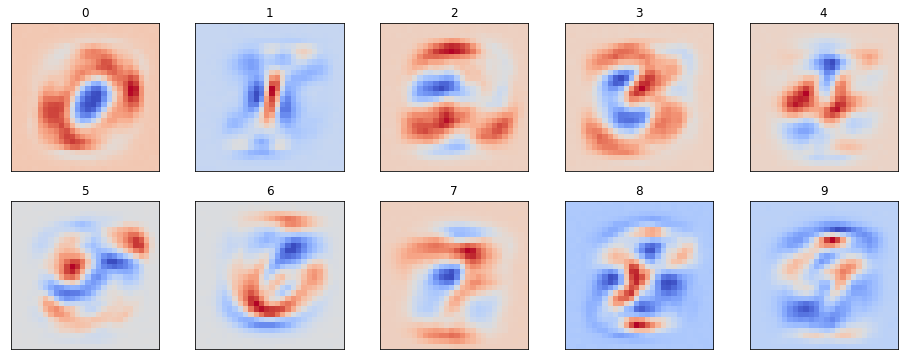

In [13]:
plt.figure(figsize=(16, 6))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(nn.Layers[0].W[i, :].reshape((28, 28)), cmap=plt.cm.coolwarm)
    plt.xticks([])
    plt.yticks([])
    plt.title("%d" % i)
plt.show()

### Neural Networks with 2 Layers

Now let's create a model with one more additional layer of 20 neurons. Let's do the optimization steps for this one. Since there are more than one layer in the model, thus there are multiple sets of weights and biases, $W^{(1)}, W^{(n)}, \cdots, W^{(n)}$ and $b^{(1)}, b^{(2)}, \cdots,b^{(n)}$ for each respective layer, where $n$ denotes Layers count. The optimizaiton steps are shown below:

$$\begin{align}
\frac{\partial \mathscr{L}}{\partial W^{(n)}} = \frac{\partial\mathscr{L}}{\partial s} &\cdot \frac{\partial s}{\partial z^{(n)}} \cdot \frac{\partial z^{(n)}}{\partial W^{(n)}}\\
\frac{\partial \mathscr{L}}{\partial b^{(n)}} = \frac{\partial\mathscr{L}}{\partial s} &\cdot \frac{\partial s}{\partial z^{(n)}} \cdot \frac{\partial z^{(n)}}{\partial b^{(n)}}
\\\\
\frac{\partial \mathscr{L}}{\partial W^{(n-1)}} = \frac{\partial\mathscr{L}}{\partial s} \cdot \frac{\partial s}{\partial z^{(n)}} &\cdot \frac{\partial z^{(n)}}{\partial a^{(n-1)}} \cdot \frac{\partial a^{(n-1)}}{\partial z^{(n-1)}} \cdot \frac{\partial z^{(n-1)}}{\partial W^{(n-1)}}\\
\frac{\partial \mathscr{L}}{\partial b^{(n-1)}} = \frac{\partial\mathscr{L}}{\partial s} \cdot \frac{\partial s}{\partial z^{(n)}} &\cdot \frac{\partial z^{(n)}}{\partial a^{(n-1)}} \cdot \frac{\partial a^{(n-1)}}{\partial z^{(n-1)}} \cdot\frac{\partial z^{(n)}}{\partial b^{(n-1)}}
\\\\
&\vdots
\\\\
\frac{\partial \mathscr{L}}{\partial W^{(1)}} = \frac{\partial\mathscr{L}}{\partial s} &\cdot \frac{\partial s}{\partial z^{(n)}} \cdot \cdots \cdot \frac{\partial a^{(1)}}{\partial z^{(1)}} \cdot \frac{\partial z^{(1)}}{\partial W^{(1)}}\\
\frac{\partial \mathscr{L}}{\partial b^{(1)}} = \frac{\partial\mathscr{L}}{\partial s} &\cdot \frac{\partial s}{\partial z^{(n)}} \cdot \cdots \cdot \frac{\partial a^{(1)}}{\partial z^{(1)}} \cdot \frac{\partial z^{(1)}}{\partial b^{(1)}}
\end{align}$$

Despite looking scary, if we pay a close attention, we can notice that:
$$
\begin{align}
\frac{\partial\mathscr{L}}{\partial W^{(i)}} = \frac{\partial\mathscr{L}}{\partial z^{(i+1)}} &\cdot \frac{\partial z^{(i+1)}}{\partial a^{(i)}} \cdot \frac{\partial a^{(i)}}{\partial z^{(i)}} \cdot \frac{\partial z^{(i)}}{\partial W^{(i)}}\\
\frac{\partial\mathscr{L}}{\partial b^{(i)}} = \frac{\partial\mathscr{L}}{\partial z^{(i+1)}} &\cdot \frac{\partial z^{(i+1)}}{\partial a^{(i)}} \cdot \frac{\partial a^{(i)}}{\partial z^{(i)}} \cdot \frac{\partial z^{(i)}}{\partial b^{(i)}}\\
\end{align}
$$

We can store $\frac{\partial\mathscr{L}}{\partial z^{(i)}}$ and use it for the next step. This will simplify the problem and reduce the computation time. The implementation of this can be seen in the `update` function of the `NeuralNetwork` class defined above:

<img src='imgs/update.png' width='100%' height='100%' style="float:center">

In [14]:
twoLayerNN = NeuralNetwork([
    Layer(784, 20, Activation="ReLU"),
    Layer(20, 10, Activation="soft")
                    ],
    cost="SCE",
    num_iterations=20,
    alpha=.05
)

In [15]:
twoLayerNN.fit(X_train, y_train, X_val, y_val, batch_size=64)

Iteration   1: training loss = 1.30 | validation loss = 0.52
Iteration   2: training loss = 0.40 | validation loss = 0.35
Iteration   3: training loss = 0.31 | validation loss = 0.30
Iteration   4: training loss = 0.28 | validation loss = 0.28
Iteration   5: training loss = 0.25 | validation loss = 0.26
Iteration   6: training loss = 0.24 | validation loss = 0.24
Iteration   7: training loss = 0.22 | validation loss = 0.23
Iteration   8: training loss = 0.21 | validation loss = 0.22
Iteration   9: training loss = 0.20 | validation loss = 0.21
Iteration  10: training loss = 0.19 | validation loss = 0.21
Iteration  11: training loss = 0.18 | validation loss = 0.20
Iteration  12: training loss = 0.18 | validation loss = 0.20
Iteration  13: training loss = 0.16 | validation loss = 0.19
Iteration  14: training loss = 0.15 | validation loss = 0.19
Iteration  15: training loss = 0.15 | validation loss = 0.18
Iteration  16: training loss = 0.15 | validation loss = 0.18
Iteration  17: training 

In [16]:
train_acc = accuracy(twoLayerNN.predict(X_train), y_train)
valid_acc = accuracy(twoLayerNN.predict(X_val), y_val)
test_acc = accuracy(twoLayerNN.predict(X_test), y_test)


print('Training accuracy =   {:.2f}%'.format(train_acc))
print('Validation accuracy = {:.2f}%'.format(valid_acc))
print('Testing accuracy = {:.2f}%'.format(test_acc))

Training accuracy =   96.02%
Validation accuracy = 95.06%
Testing accuracy = 94.68%
